In [4]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import math
import random
import pickle

In [23]:
labels = ['BackG', '5N', '7n', '7N', '12N', 'Pn', 'VLL', 
          '6N', 'Amb', 'R', 'Tz', 'RtTg', 'LRt', 'LC', 'AP', 'sp5']

In [5]:
class Hypersphere_abstain:
    
    def __init__(self, center, radius, threshold, label, alpha, beta, err, weighted_err, unweighted_err,
                 label_distribution, center_index, neighbor_indices, d_var, max_q_var):
        
        self.center = center
        self.radius = radius
        self.thres = threshold
        self.label = label
        self.alpha = alpha
        self.beta = beta
        self.err = err # PSEUDO error
        self.weighted_err = weighted_err
        self.unweighted_err = unweighted_err
        self.label_distribution = label_distribution
        self.center_index = center_index
        self.neighbor_indices = neighbor_indices
        
        # Hack
        self.d_var = d_var
        self.max_q_var = max_q_var
        
class WeakLearner_generator:
    
    def __init__(self, init_radius, abstain_thres, err_thres, growth_radius):
        
        self.init_radius = init_radius
        self.abstain_thres = abstain_thres
        self.err_thres = err_thres
        self.growth_radius = growth_radius
        
    def generate_M2(self, train_X, train_y, train_kernel, D, Q, mask, n_class):
        
        n_samples = train_X.shape[0]
        D = D.reshape((n_samples, ))

        # Choose an exemplar
        exemplar_index = np.random.choice(range(n_samples), p=D.tolist())
        exemplar = train_X[exemplar_index]

        # Retrieve scores to exemplar and sort
        scores = train_kernel[exemplar_index]
        sorted_scores = np.sort(scores)[::-1]
        sorted_indices = np.argsort(scores)[::-1]
        sorted_y = train_y[sorted_indices].astype('int64')
        sorted_D = D[sorted_indices]
        sorted_Q = Q[sorted_indices]
        sorted_mask = mask[sorted_indices]

        # Calculate plurarity and percentage of initial sphere
        count = np.bincount(sorted_y[:self.init_radius],
                            weights=sorted_D[:self.init_radius],
                            minlength=n_class)
        unweighted_count = np.bincount(sorted_y[:self.init_radius],
                                       minlength=n_class)
        y_of_interest = np.argmax(count)
        percentage = count[y_of_interest]*1.0 / np.sum(sorted_D[:self.init_radius])

        # Abstain test (HACK to avoid zero threshold)
        if percentage<self.abstain_thres or np.sum(sorted_scores)==0.0:
            return None, None, None

        # Caculate best radius
        index_of_interest = np.array([y_==y_of_interest for y_ in sorted_y])
        weight_of_interest = np.cumsum(index_of_interest*sorted_D)
        best_radius = self.init_radius
        best_percentage = percentage
        for i in range(self.init_radius+self.growth_radius, n_samples, self.growth_radius):
            perc = weight_of_interest[i-1]*1.0 / np.sum(sorted_D[:i])
            if perc>best_percentage:
                best_radius = i
                best_percentage = perc

        # Calculate label distritbution
        label_distribution = np.bincount(sorted_y[:best_radius], minlength=n_class)
        
        # Prediction score by distribution
        label_distribution = label_distribution*1.0 / np.sum(label_distribution)
        label_conf = np.tile(label_distribution, (n_samples, 1))
        
        # Prediction score by max (1 or 0)
#         label_conf = np.zeros(label_distribution.shape)
#         label_conf[y_of_interest] = 1.0
#         label_conf = np.tile(label_conf, (n_samples, 1))

        # Calculate three terms in pseudo loss
        ones_term = np.ones((n_samples,)).astype('float')
        label_term = np.sum(sorted_mask*label_conf, axis=1).astype('float')
        nonlabel_sum = np.sum(sorted_Q*label_conf, axis=1).astype('float')
        
        # Calculate pseudo loss
        p_err_best = 0.5 * np.sum(sorted_D[:best_radius]* \
                       (ones_term[:best_radius]- \
                        label_term[:best_radius]+ \
                        nonlabel_sum[:best_radius]))
        p_err = 0.5 * np.sum(sorted_D*(ones_term-label_term+nonlabel_sum))
#         print 'p_err: ', p_err
        
        # Error test
        if p_err>self.err_thres:
            return None, None, None
        
        # Calculate alpha
        epsilon = 1.0e-24
        alpha = math.log((1.0-p_err+epsilon)/(p_err+epsilon))
        beta = (p_err+epsilon)*1.0/(1.0-p_err-epsilon)

        # Return weakleaner
        err = np.sum(~index_of_interest[:best_radius])*1.0 / best_radius
        w_err = np.sum(~index_of_interest[:best_radius]*sorted_D[:best_radius]) / np.sum(sorted_D[:best_radius])
        threshold = sorted_scores[best_radius-1]
        
        d_var = np.var(D)
        max_q_var= np.max(np.var(sorted_Q, axis=1))
        
        
        h = Hypersphere_abstain(exemplar, best_radius, threshold, y_of_interest,
                                alpha, beta, p_err, w_err, err, label_distribution,
                                exemplar_index, sorted_indices, d_var, max_q_var)
        
        return h, sorted_mask, label_conf
    

In [6]:
# Adaboost.M2

class Adaboost_M2:
    
    def __init__(self, iterations, n_class, weaklearner):
        
        self.T = iterations
        self.H = []
        self.D = None
        self.Q = None
        self.label_mask = None
        self.n_class = n_class
        self.weaklearner = weaklearner
    
    def train(self, train_X, train_y, train_kernel):
        
        n_samples = train_X.shape[0]
        
        # Create column mask for weights
        rows = list(xrange(n_samples))
        cols = train_y.astype('int64').tolist()
        self.label_mask = np.zeros((n_samples, self.n_class), dtype=bool)
        self.label_mask[rows, cols] = True
        
        # Initialize weights
        self.D = np.ones((n_samples, 1)) * (1.0/n_samples)
        self.Q = np.zeros((n_samples, self.n_class))
        self.Q += ~self.label_mask*self.D * (1.0/(self.n_class-1))
        
        for t in xrange(self.T):

            if t%100==0:
                print 't: ', t
            
            # Generate weaklearner
            h, h_neighbor_label_mask, label_confidences = \
                self.weaklearner.generate_M2(train_X, train_y, train_kernel, self.D, self.Q, self.label_mask, self.n_class)
            
            # Check abstained
            if not h:
                continue
                
            self.H.append(h)

            # Reweight
            base_term = h.beta*np.ones((n_samples, self.n_class))
            ones_term = np.ones((n_samples, self.n_class))
            label_term = np.sum(h_neighbor_label_mask*label_confidences, axis=1).reshape((n_samples, 1))
            label_term = np.tile(label_term, ((1, self.n_class)))
            
            power_term = 0.5*(ones_term + label_term - \
                         ~h_neighbor_label_mask*label_confidences)
            
            self.Q[h.neighbor_indices] = self.Q[h.neighbor_indices] * \
                                            np.power(base_term, power_term)
            
            # Normalize
            Q_sample_sum = np.sum(self.Q, axis=1).reshape((n_samples, 1))
            self.Q = self.Q / Q_sample_sum
            self.D = Q_sample_sum / np.sum(Q_sample_sum)
            
        print 'Num classifiers: ', len(self.H)

    def predict(self, train_X, train_y, train_kernel=None):

        no_kernel = train_kernel==None
        n_samples = train_X.shape[0]
        cumulative_prob = np.zeros((n_samples, self.n_class)).astype('float')
        staged_pred_y = np.zeros((len(self.H), n_samples)).astype('int64')
        print 'n: ', n_samples
        
        if no_kernel:
            
            def compute_intersection_kernel_oneJob(i):
                dist = np.minimum(self.H[i].center, test_X)
                dist = np.sum(dist, axis=1).reshape((1, n_samples))
                return dist
            
            score_kernel = np.concatenate([compute_intersection_kernel_oneJob(i) for i in xrange(len(self.H))], axis=0)
            print 'Test kernel shape: ', score_kernel.shape
            
        else:
            score_kernel = None

        for i in xrange(1, len(self.H)+1):
            
            clf = self.H[i-1]
            
            score = np.copy(score_kernel[i-1]) if no_kernel else np.copy(train_kernel[clf.center_index])
            score[score < clf.thres] = 0.0 #Abstain
            score[score >= clf.thres] = math.log(1.0/clf.beta) #Predict as clf.label
        
            label_weights = (clf.label_distribution*1.0/np.sum(clf.label_distribution))
            cumulative_prob += np.multiply(score.reshape((n_samples,1)), label_weights.reshape((1,self.n_class)))
            
            if i%50==0:
                print i, clf.radius,
                print 'Abstained: ', np.sum(score==0.0),
                print 'Beta: ', clf.beta,
                print 'Label: ', clf.label
                
            max_prob = np.max(cumulative_prob, axis=1)
            pred_y = np.argmax(cumulative_prob, axis=1)
            pred_y[max_prob==0.0] = 0
            staged_pred_y[i-1,:] = pred_y

        print 'Correct predictions: ', np.sum(train_y==staged_pred_y[-1])
        
        return staged_pred_y


In [7]:
t = time.time()

# Load preprocessed data
train_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_data.bp')
train_y = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_labels.bp')
train_kernel = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_spm_dist_mat.bp')
train_fnames = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_fnames.bp')

test_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_data.bp')
test_y = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_labels.bp')
test_fnames = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_fnames.bp')

sys.stderr.write('Load time: %f seconds\n' % (time.time() - t)) 

Load time: 23.253974 seconds


In [8]:
print train_X.shape
print train_kernel.shape
print test_X.shape

(10769, 200)
(10769, 10769)
(2695, 200)


In [9]:
t = time.time()

# Setup
weak = WeakLearner_generator(init_radius=50, 
                             abstain_thres=0.5,
                             err_thres=1.0,
                             growth_radius=10)
ada = Adaboost_M2(iterations=2000, 
                  n_class=16, 
                  weaklearner=weak)

sys.stderr.write('Setup time: %f seconds\n' % (time.time() - t))

Setup time: 0.000213 seconds


In [10]:
# Train

t = time.time()
ada.train(train_X, train_y, train_kernel)
sys.stderr.write('Train time: %f seconds\n' % (time.time() - t))

t:  0
t:  100
t:  200
t:  300
t:  400
t:  500
t:  600
t:  700
t:  800
t:  900
t:  1000
t:  1100
t:  1200
t:  1300
t:  1400
t:  1500
t:  1600
t:  1700
t:  1800
t:  1900
Num classifiers:  373


Train time: 22.510316 seconds


In [11]:
# Hypersphere center labels

print 'Labels: ', set([h.label for h in ada.H])

Labels:  set([0, 2, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15])


In [12]:
# Predict train

t = time.time()
staged_pred_y = ada.predict(train_X, train_y, train_kernel)
sys.stderr.write('Test time: %f seconds\n' % (time.time() - t)) # ~ 12s / 12k training data

n:  10769
50 60 Abstained:  10705 Beta:  0.98775384379 Label:  2
100 50 Abstained:  10719 Beta:  0.985018242501 Label:  6
150 50 Abstained:  10719 Beta:  0.984225014234 Label:  15
200 70 Abstained:  10699 Beta:  1.02603661605 Label:  14
250 80 Abstained:  10689 Beta:  1.00370941532 Label:  14
300 50 Abstained:  10719 Beta:  1.00180751397 Label:  14
350

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Test time: 1.062771 seconds


 60 Abstained:  10704 Beta:  0.997482482675 Label:  2
Correct predictions:  2378


In [13]:
# Predicted labels

final_y = staged_pred_y[-1]
print 'Label 0: ', np.sum(final_y==0)
print 'Labels: ', set(final_y)

Label 0:  7367
Labels:  set([0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15])


In [14]:
# Predict test

t = time.time()
staged_pred_y_test = ada.predict(test_X, test_y)
sys.stderr.write('Test time: %f seconds\n' % (time.time() - t)) # ~ 12s / 12k training data

n:  2695
Test kernel shape:  (373, 2695)
50 60 Abstained:  2685 Beta:  0.98775384379 Label:  2
100 50 Abstained:  2683 Beta:  0.985018242501 Label:  6
150 50 Abstained:  2684 Beta:  0.984225014234 Label:  15
200 70 Abstained:  2684 Beta:  1.02603661605 Label:  14
250 80 Abstained:  2669 Beta:  1.00370941532 Label:  14
300 50 Abstained:  2687 Beta:  1.00180751397 Label:  14
350 60 Abstained:  2672 Beta:  0.997482482675 Label:  2
Correct predictions:  583


Test time: 1.281861 seconds


In [15]:
# Predicted Labels

final_y = staged_pred_y_test[-1]
print 'Label 0: ', np.sum(final_y==0)
print 'Labels: ', set(final_y)

Label 0:  1829
Labels:  set([0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15])


In [16]:
# Neighbor Scores

for h in ada.H[:10]:
    print train_kernel[h.center_index,h.neighbor_indices[:3]]

[ 1.          0.66228036  0.66110957]
[ 1.          0.77008917  0.7310614 ]
[ 1.          0.36904762  0.36666667]
[ 1.          0.59112395  0.58946505]
[ 1.          0.64726576  0.64123385]
[ 1.          0.28571429  0.22580645]
[ 1.          0.85371799  0.84947159]
[ 1.          0.73809524  0.69444444]
[ 1.          0.88983913  0.87600849]
[ 1.          0.64352057  0.63438007]


In [17]:
# Calculate true positive and abstain rate

train_tp=[]
train_acc=[]
train_abstain_rate = []
n_training = staged_pred_y.shape[1]
for pred_y in staged_pred_y:
    n_abstain = np.sum(pred_y==0)
    n_tp_total = np.sum(pred_y!=0)
    n_tp_correct = np.sum(np.logical_and(pred_y!=0,pred_y==train_y))
    n_correct = np.sum(pred_y==train_y)
    train_tp.append(1.0 * n_tp_correct / n_tp_total)
    train_acc.append(1.0 * n_correct / n_training)
    train_abstain_rate.append(1.0 * n_abstain / n_training)
    
test_tp=[]
test_acc=[]
test_abstain_rate = []
n_testing = staged_pred_y_test.shape[1]
for pred_y in staged_pred_y_test:
    n_abstain = np.sum(pred_y==0)
    n_tp_total = np.sum(pred_y!=0)
    n_tp_correct = np.sum(np.logical_and(pred_y!=0,pred_y==test_y))
    n_correct = np.sum(pred_y==test_y)
    test_tp.append(1.0 * n_tp_correct / n_tp_total)
    test_acc.append(1.0 * n_correct / n_testing)
    test_abstain_rate.append(1.0 * n_abstain / n_testing)
    
print 'Training: ', n_training
print 'Testing: ', n_testing

Training:  10769
Testing:  2695


In [18]:
# Pseudo loss and variances

p_loss = []
d_var = []
q_var = []
for h in ada.H:
    p_loss.append(h.err)
    d_var.append(h.d_var)
    q_var.append(h.max_q_var)

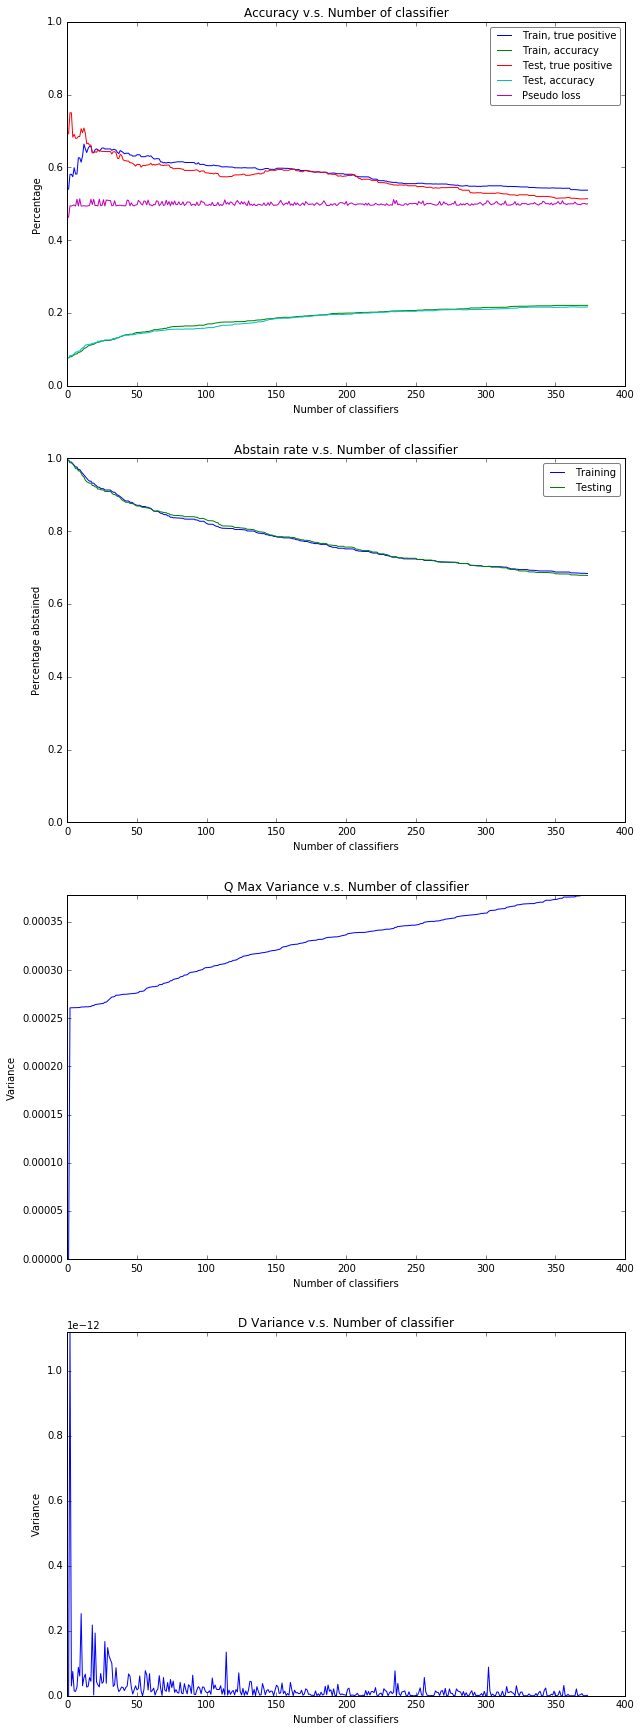

In [22]:
# Plot true positive and abstain rate

n_clf = len(ada.H);
plt.figure(figsize=(10,30));
plt.subplot(411);
plt.title("Accuracy v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Percentage");
plt.ylim([0.0, 1.0]);
plt.plot(range(1, n_clf + 1), train_tp, label='Train, true positive');
plt.plot(range(1, n_clf + 1), train_acc, label='Train, accuracy');
plt.plot(range(1, n_clf + 1), test_tp, label='Test, true positive');
plt.plot(range(1, n_clf + 1), test_acc, label='Test, accuracy');
plt.plot(range(1, n_clf + 1), p_loss, label='Pseudo loss');
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
# plt.hlines(0.60, 0, n_clf, linestyles=':', color='grey');
# plt.hlines(0.25, 0, n_clf, linestyles=':', color='grey');

plt.subplot(412);
plt.title("Abstain rate v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Percentage abstained");
plt.ylim([0.0, 1.0]);
plt.plot(range(1, n_clf + 1), train_abstain_rate, label='Training');
plt.plot(range(1, n_clf + 1), test_abstain_rate, label='Testing');
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
# plt.hlines(0.58, 0, n_clf, linestyles=':', color='grey');

plt.subplot(413);
plt.title("Q Max Variance v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Variance");
plt.ylim([0.0, max(q_var)]);
plt.plot(range(1, n_clf + 1), q_var, label='Q');

plt.subplot(414);
plt.title("D Variance v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Variance");
plt.ylim([0.0, max(d_var)]);
plt.plot(range(1, n_clf + 1), d_var, label='D');

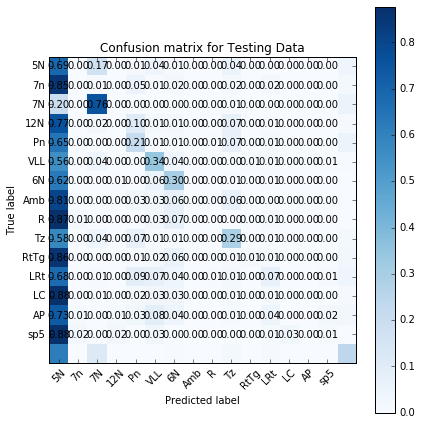

In [24]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if cm.dtype.type is np.int_:
        fmt = '%d'
    else:
        fmt = '%.2f'
    
    for x in xrange(len(labels)):
        for y in xrange(len(labels)):
            if not np.isnan(cm[y,x]):
                plt.text(
                    x,y,
                   fmt % cm[y,x],  
                   horizontalalignment='center',
                   verticalalignment='center');

cm_test = confusion_matrix(test_y, staged_pred_y_test[-1]);
cm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis];
plot_confusion_matrix(cm_test, labels[1:], 'Confusion matrix for Testing Data');

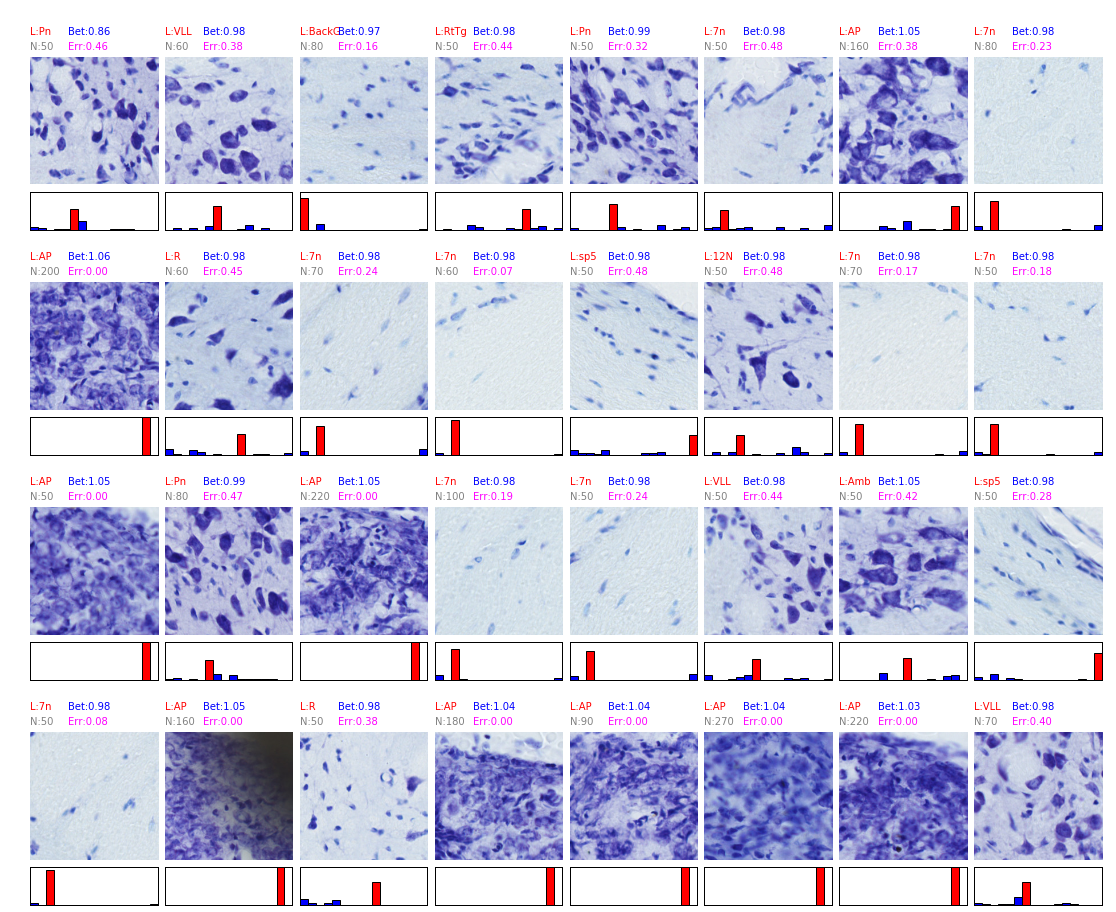

In [25]:
# Example hyperspheres

subplot_width = 2.4;
subplot_height = 4;
fig_row = 4;
fig_col = 8;
plt.figure(figsize=(subplot_width * fig_col, subplot_height * fig_row));
plt.title('Information of hypersphere: (label, alpha, radius, number of examples)');
for row in range(0, fig_row):
    for col in range(0, fig_col):
        i = row * fig_col + col;
        ax0 = plt.subplot2grid((5 * fig_row, 3 * fig_col), (5 * row, 3 * col), colspan=3);
        ax0.text(0.0, 0.4, 'L:{}'.format(labels[ada.H[i].label]), fontsize=10, color='red');
        ax0.text(0.0, 0.0, 'N:{}'.format(ada.H[i].radius), fontsize=10, color='grey');
        ax0.text(0.3, 0.4, 'Bet:{:.2f}'.format(ada.H[i].beta), fontsize=10, color='blue');
        ax0.text(0.3, 0.0, 'Err:{:.2f}'.format(ada.H[i].unweighted_err), fontsize=10, color='magenta');
        ax0.axison=False;
        
        img=imread(train_fnames[ada.H[i].center_index]);
        ax1 = plt.subplot2grid((5 * fig_row, 3 * fig_col), (5 * row + 1, 3 * col), rowspan=3, colspan=3);
        ax1.imshow(img, cmap=plt.cm.gray);
        ax1.axis('off');
        
        ax2 = plt.subplot2grid((5 * fig_row, 3 * fig_col), (5 * row + 4, 3 * col), colspan=3);
        ax2bar = ax2.bar(np.arange(0, 16), ada.H[i].label_distribution*1.0/sum(ada.H[i].label_distribution), width=1);
        ax2bar[ada.H[i].label].set_color('red');
        ax2bar[ada.H[i].label].set_edgecolor('black');
        ax2.axes.get_yaxis().set_visible(False);
        ax2.axes.get_xaxis().set_visible(False);
        ax2.axes.set_ylim([0.0, 1.0]);

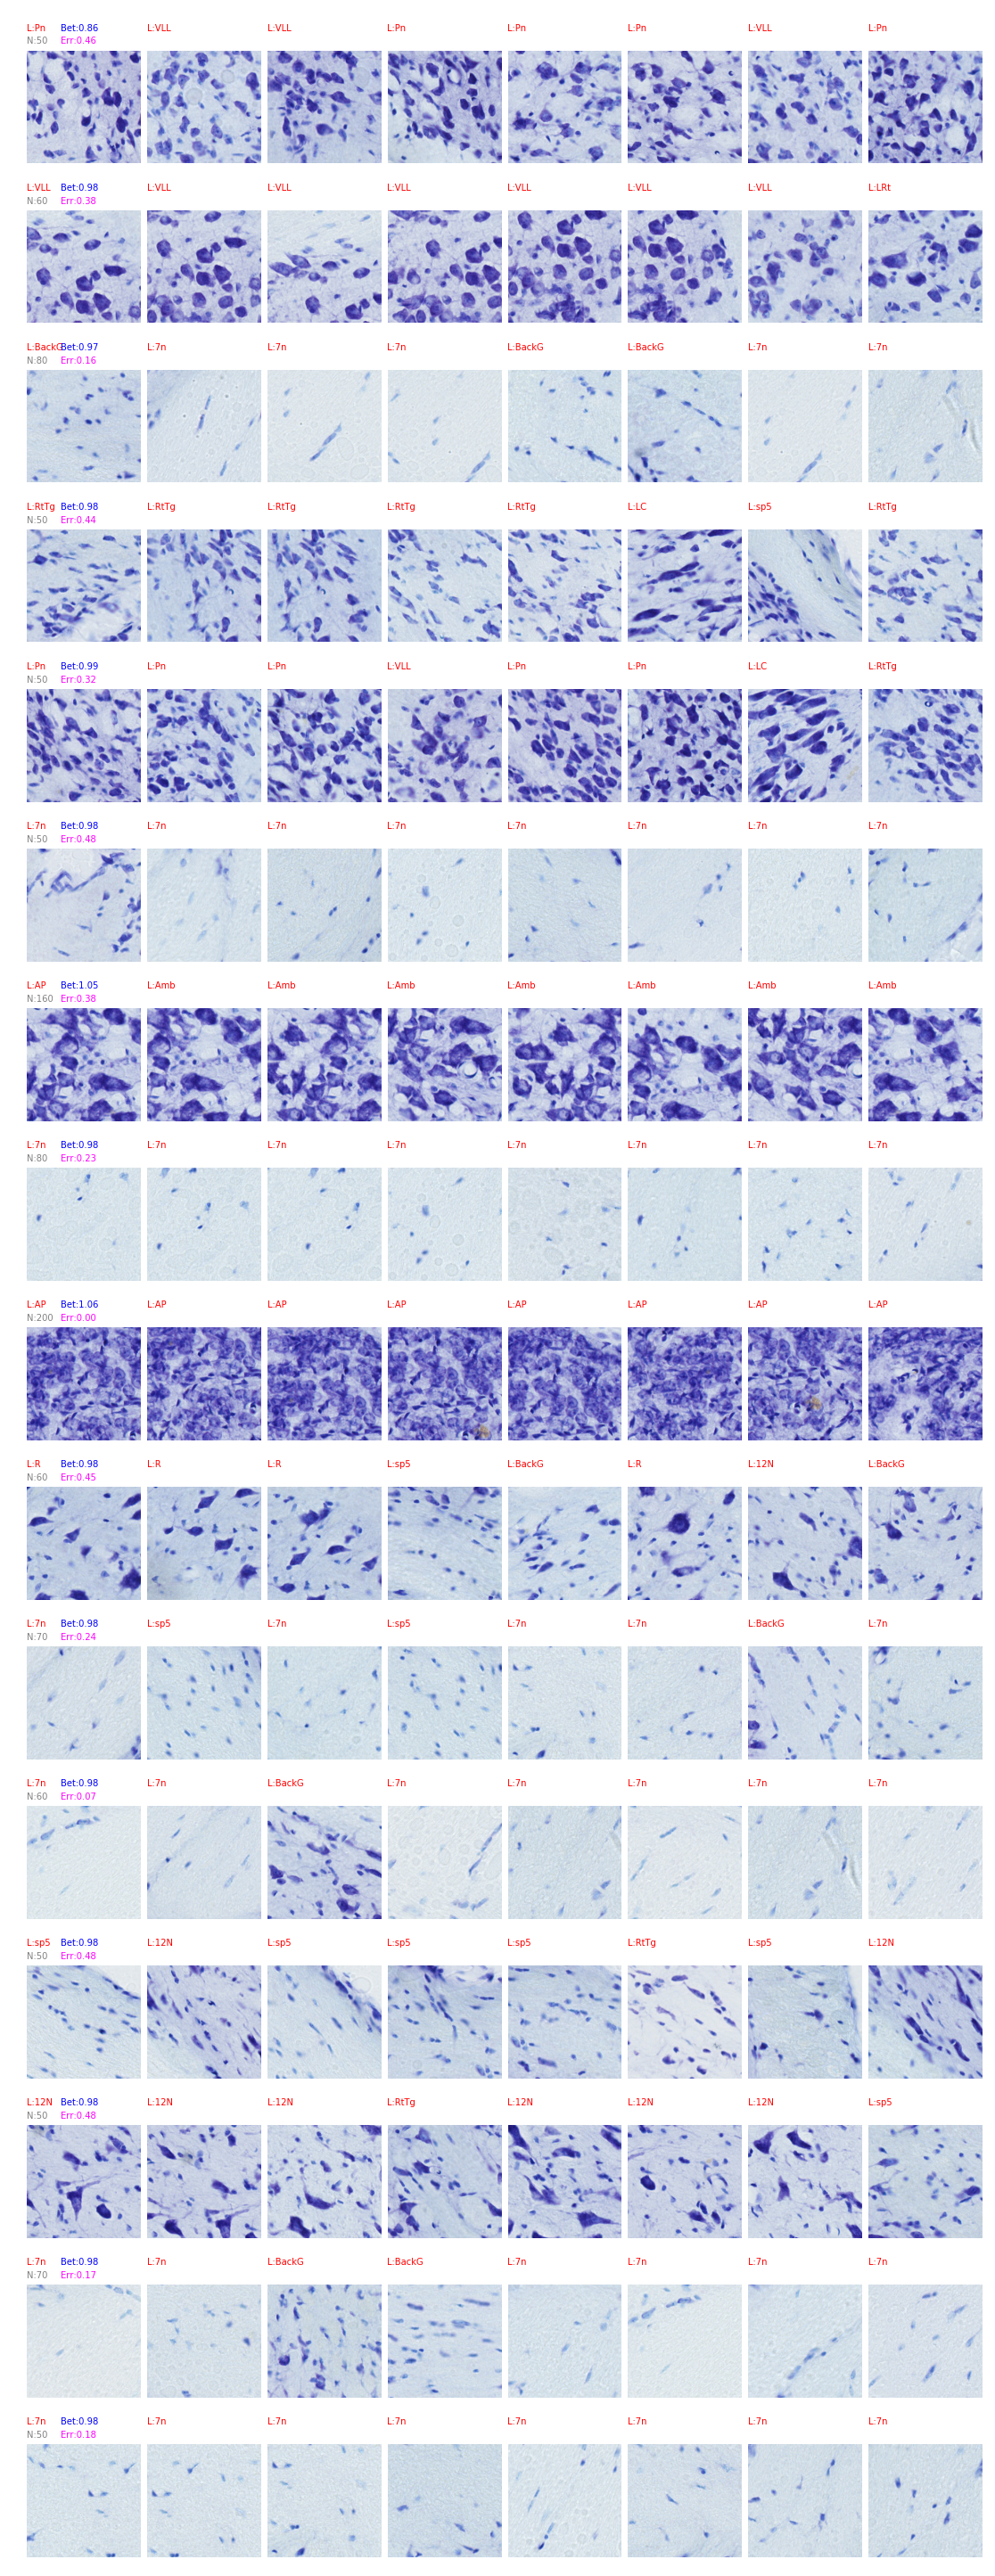

In [26]:
# Example hypersphere centers and their closest neighbors

subplot_width = 2.4;
subplot_height = 3.2;
fig_row = 16;
fig_col = 8;
plt.figure(figsize=(subplot_width * fig_col, subplot_height * fig_row));
for h in xrange(fig_row):
    for n in xrange(fig_col):
        ax0 = plt.subplot2grid((4 * fig_row, 3 * fig_col), (4 * h, 3 * n), colspan=3);
        
        if n==0:
            ax0.text(0.0, 0.4, 'L:{}'.format(labels[ada.H[h].label]), fontsize=10, color='red');
            ax0.text(0.0, 0.0, 'N:{}'.format(ada.H[h].radius), fontsize=10, color='grey');
            ax0.text(0.3, 0.4, 'Bet:{:.2f}'.format(ada.H[h].beta), fontsize=10, color='blue');
            ax0.text(0.3, 0.0, 'Err:{:.2f}'.format(ada.H[h].unweighted_err), fontsize=10, color='magenta');
        else:
            ax0.text(0.0, 0.4, 'L:{}'.format(labels[int(train_y[ada.H[h].neighbor_indices[n]])]), fontsize=10, color='red');
        ax0.axison=False;
        
        img=imread(train_fnames[ada.H[h].neighbor_indices[n]]);
        ax1 = plt.subplot2grid((4 * fig_row, 3 * fig_col), (4 * h + 1, 3 * n), rowspan=3, colspan=3);
        ax1.imshow(img, cmap=plt.cm.gray);
        ax1.axis('off');